In [2]:
import skimage

from skimage.filters import threshold_otsu as th_otsu
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen as th_yen
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import os
filename = os.path.join(os.getcwd(), 'brain_tumor.png')
from skimage import io
img = io.imread(filename)
percent = 5

In [3]:
skimage.img_as_ubyte(skimage.util.random_noise(img,'s&p', percent=5/100))

array([[[255, 255, 255],
        [  0, 150, 150],
        [  0, 150, 150],
        ...,
        [153, 153, 153],
        [255, 156, 156],
        [157, 157, 157]],

       [[255, 255, 255],
        [151, 151, 151],
        [151, 151, 151],
        ...,
        [145, 145, 145],
        [149, 149, 149],
        [151, 151,   0]],

       [[255, 255, 255],
        [151, 151, 151],
        [151, 151, 151],
        ...,
        [138, 138, 255],
        [141, 141, 141],
        [139, 139, 139]],

       ...,

       [[255, 255, 255],
        [ 93, 255, 255],
        [ 99,   0,  99],
        ...,
        [ 95,  95,  95],
        [ 95,  95,  95],
        [ 95,  95,  95]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [20]:
##scipy
import scipy
result = scipy.ndimage.gaussian_filter(img, sigma=2)

C:\Users\blasz\AppData\Local\Temp\ipykernel_2876\353464313.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])


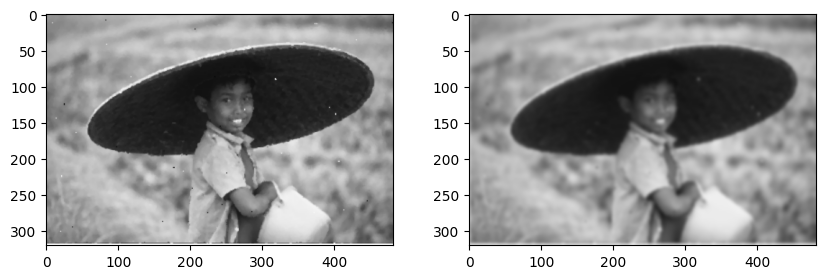

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2,1)
ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])

ax[0].imshow(img)
ax[1].imshow(result)